In [15]:
import numpy as np
import pandas as pd

from src.constant import DATA_DIR, DATABASE_DIR
from src.database import DB
from src.database.queries import *
from src.instance.InstanceList import InstanceList
from src.instance.TSP_Instance import TSP_from_index_file
from src.solver.TSP_LKH_Solver import TSP_LKH_Solver
from src.aac.SurrogateEstimator import Estimator1

import matplotlib.pyplot as plt

plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.2
plt.rcParams["grid.color"] = "#cccccc"
plt.rcParams["axes.xmargin"] = 0


In [2]:
generators = [
    "cluster_netgen",
    "compression",
    "expansion",
    "explosion",
    "grid",
    "cluster",
    "implosion",
    "linearprojection",
    "rotation",
    "uniform_portgen",
]

test_instances = TSP_from_index_file(filepath=DATA_DIR / "TSP" / "TEST" / "index.json")

id_to_generator_name = {
    instance.id(): instance.filepath.parts[-2] for instance in test_instances
}

id_to_name = {
    instance.id(): instance.filepath.parts[-1] for instance in test_instances
}

In [3]:
# X_list = []
# y_list = []

# for prefix in ["run-plain-30", "run-plain-250", "run-plain-500"]:
#     for db_path in DATABASE_DIR.glob(f"{prefix}-*.db"):
#         db = DB(db_path)
#         X, y = get_model_training_data(db)
#         X_list.append(X)
#         y_list.append(y)
    
# X_test = np.concatenate(X_list, axis=0)
# y_test = np.concatenate(y_list, axis=0)

In [4]:
db_path = list(DATABASE_DIR.glob(f"run-plain-30-*.db"))[0]
db = DB(db_path)

X, y = get_model_training_data(db)

estimator = Estimator1(
    max_cost=TSP_LKH_Solver.MAX_COST, estimator_pct=0.5
)
estimator.fit(X, y)

Estimator1(classifier=RandomForestClassifier(class_weight='balanced',
                                             max_depth=12, max_features=0.4,
                                             min_samples_leaf=0.03,
                                             min_samples_split=0.05,
                                             n_estimators=200, n_jobs=5,
                                             random_state=0),
           max_cost=100.0,
           regressor=RandomForestRegressor(max_depth=12, max_features=0.4,
                                           min_samples_leaf=0.03,
                                           min_samples_split=0.05,
                                           n_estimators=200, n_jobs=5,
                                           random_state=0))

In [31]:
query = f"""
    select 
        {db.SCHEMA.EVALUATIONS}.cost,
        {db.SCHEMA.SOLVERS}.*,
        {db.SCHEMA.INSTANCES}.*
    from {db.SCHEMA.EVALUATIONS}
    join {db.SCHEMA.INSTANCES} on {db.SCHEMA.EVALUATIONS}.instance_id = {db.SCHEMA.INSTANCES}.id
    join {db.SCHEMA.SOLVERS} on {db.SCHEMA.EVALUATIONS}.solver_id = {db.SCHEMA.SOLVERS}.id
    """
df = db.query2df(query)
df = df.drop(columns=["id", "filepath", "optimum"])
df = df.dropna()
y = df["cost"]
X = df.drop(columns="cost")
COLUMNS = X.columns

In [28]:
s = pd.Series(dict(zip(X.columns, estimator.classifier.feature_importances_)))

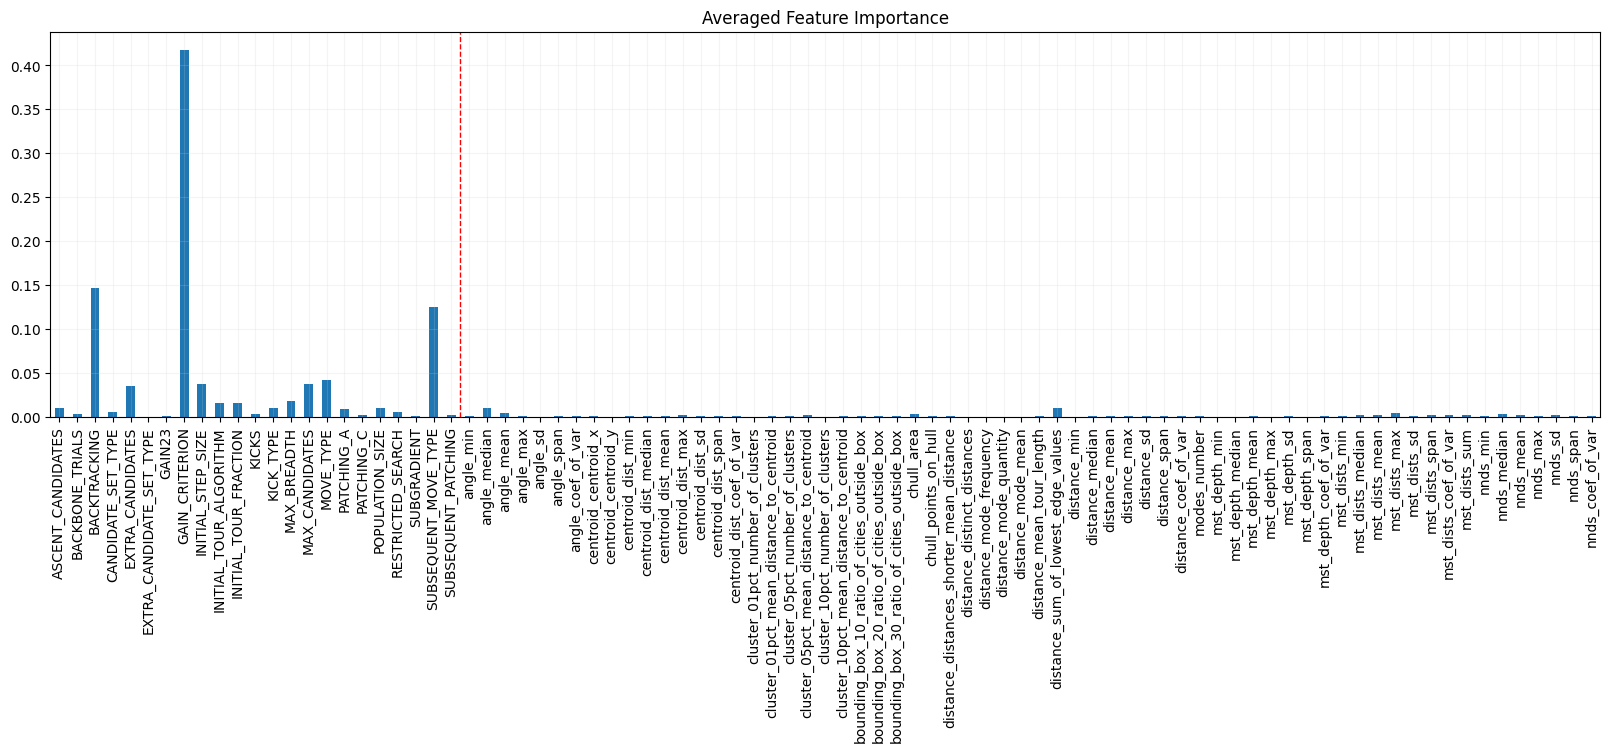

In [29]:
s.plot.bar(figsize=(20, 5))
plt.axvline(x=22.5, c="red", lw=1, ls="--")
plt.title("Averaged Feature Importance")
plt.savefig("feature_importance.png", dpi=300, bbox_inches="tight")
plt.show()

In [41]:
prefix = "run-plain-30"

feature_importance_regressor = []
feature_importance_classifier = []

for db_path in DATABASE_DIR.glob(f"{prefix}-*.db"):
    db = DB(db_path)

    X, y = get_model_training_data(db)
    estimator = Estimator1(
        max_cost=TSP_LKH_Solver.MAX_COST, estimator_pct=0.5
    )
    estimator.fit(X, y)

    s = pd.Series(dict(zip(COLUMNS, estimator.classifier.feature_importances_)))
    feature_importance_classifier.append(s)

    s = pd.Series(dict(zip(COLUMNS, estimator.regressor.feature_importances_)))
    feature_importance_regressor.append(s)

In [45]:
prefix = "run-plain-250"

feature_importance_regressor = []
feature_importance_classifier = []

for db_path in DATABASE_DIR.glob(f"{prefix}-*.db"):
    db = DB(db_path)

    X, y = get_model_training_data(db)
    estimator = Estimator1(
        max_cost=TSP_LKH_Solver.MAX_COST, estimator_pct=0.5
    )
    estimator.fit(X, y)

    s = pd.Series(dict(zip(COLUMNS, estimator.classifier.feature_importances_)))
    feature_importance_classifier.append(s)

    s = pd.Series(dict(zip(COLUMNS, estimator.regressor.feature_importances_)))
    feature_importance_regressor.append(s)

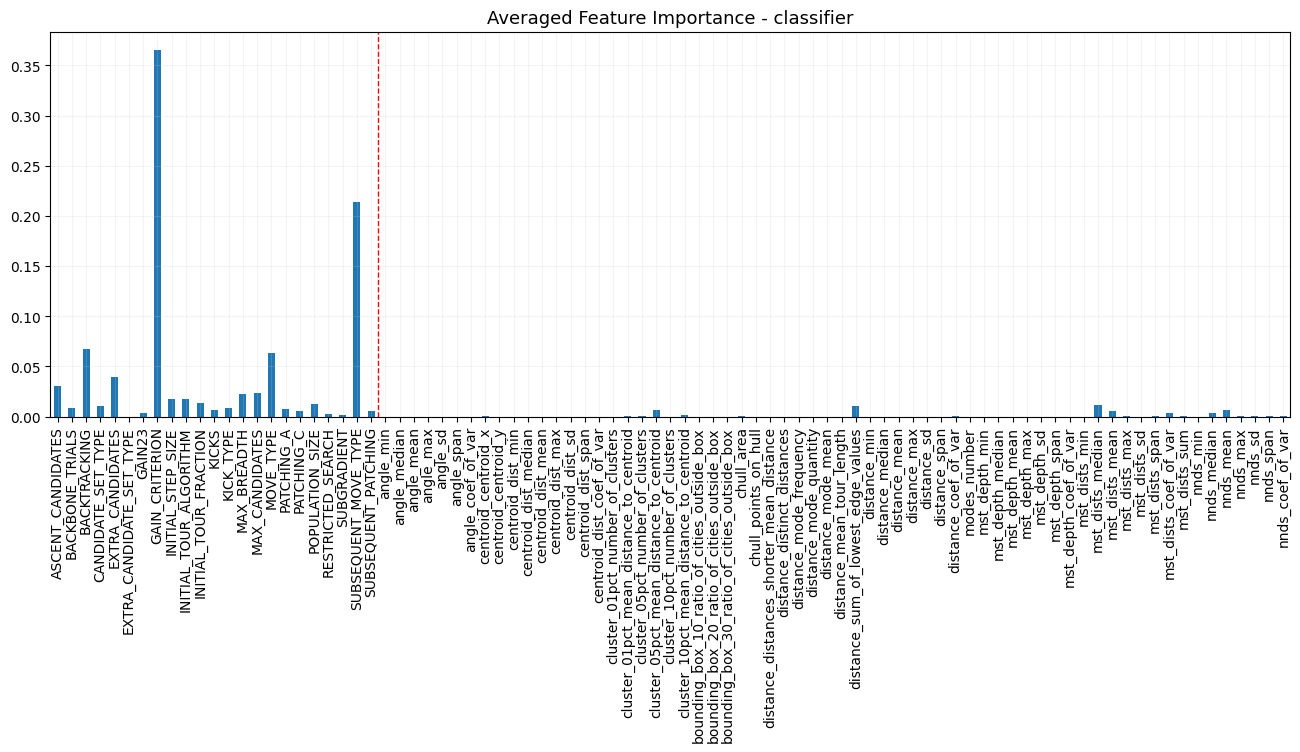

In [50]:
s = pd.concat(feature_importance_classifier, axis=1).mean(axis=1)
s.plot.bar(figsize=(16, 5))
plt.axvline(x=22.5, c="red", lw=1, ls="--")
plt.title("Averaged Feature Importance - classifier", size=13)
plt.savefig("feature_importance_classifier.png", dpi=300, bbox_inches="tight")
plt.show()

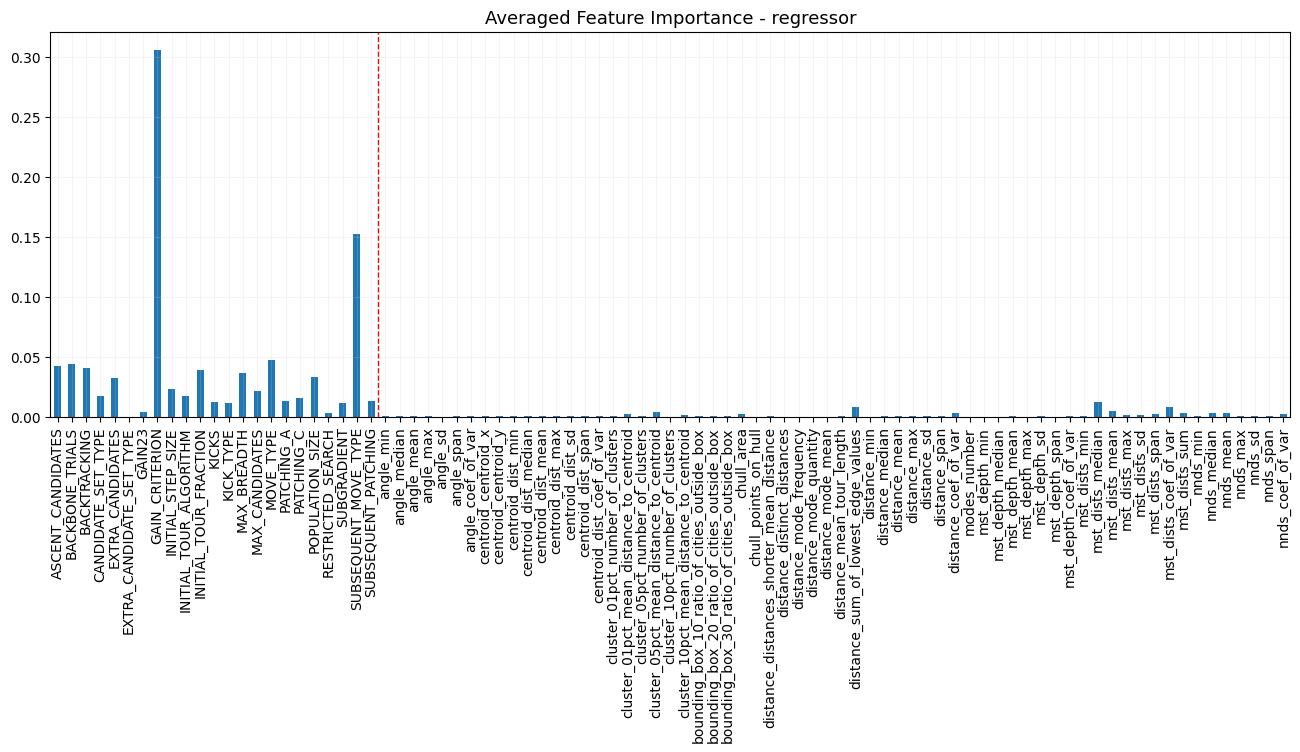

In [52]:
s = pd.concat(feature_importance_regressor, axis=1).mean(axis=1)
s.plot.bar(figsize=(16, 5))
plt.axvline(x=22.5, c="red", lw=1, ls="--")
plt.title("Averaged Feature Importance - regressor", fontsize=13)
plt.savefig("feature_importance_regressor.png", dpi=300, bbox_inches="tight")
plt.show()

In [44]:
prefix = "run-plain-500"

acc_list = []
rmse_list = []
training_data_shape_list = []
non_timeout_training_data_shape_list = []
for db_path in DATABASE_DIR.glob(f"{prefix}-*.db"):
    db = DB(db_path)

    X, y = get_model_training_data(db)
    estimator = Estimator1(
        max_cost=TSP_LKH_Solver.MAX_COST, estimator_pct=0.5
    )
    estimator.fit(X, y)
    acc_, rmse = estimator.score(X_test, y_test)
    training_data_shape = X.shape[0]
    non_timeout_training_data_shape = X[estimator._mask_non_timeout].shape[0]
    acc_list.append(acc_)
    rmse_list.append(rmse)
    training_data_shape_list.append(training_data_shape)
    non_timeout_training_data_shape_list.append(non_timeout_training_data_shape)

acc = np.mean(acc_list)
rmse = np.mean(rmse_list)
training_data_shape = np.mean(training_data_shape_list)
non_timeout_training_data_shape = np.mean(non_timeout_training_data_shape_list)

print(f"{acc=:.4f}, {rmse=:.4f}, {training_data_shape=:.1f}, {non_timeout_training_data_shape=:.1f}")

acc=0.7990, rmse=2.0140, training_data_shape=75000.0, non_timeout_training_data_shape=39751.0


In [45]:
X_test.shape[0]

1170000

In [39]:
2/4 * 4500

2250.0

In [33]:
estimator.score(X_test, y_test)

(0.79, 2.05)

In [17]:
rows = []
for idx, db_path in enumerate(DATABASE_DIR.glob(f"{PREFIX}-*.db")):
    db = DB(db_path)
    results = pd.read_sql_query("SELECT * FROM results", db._conn)
    results_config = results.loc[results["prefix"].str.startswith("config"), :]
    config_cutoff_ratio = (results_config["cost"] == TSP_LKH_Solver.MAX_COST).mean()
    config_error_ratio = (results_config["error"] == 1).mean()
    config_surrogate_ratio = (results_config["surrogate"] == 1).mean()

    results_test = results.loc[results["prefix"].str.startswith("test"), :]
    test_cutoff_ratio = (results_test["cost"] == TSP_LKH_Solver.MAX_COST).mean()
    test_error_ratio = (results_test["error"] == 1).mean()

    rows.append({
        "name": db_path.name,
        "config_cutoff_ratio": config_cutoff_ratio,
        "config_error_ratio": config_error_ratio,
        "config_surrogate_ratio": config_surrogate_ratio,
        "test_cutoff_ratio": test_cutoff_ratio,
        "test_error_ratio": test_error_ratio,
    })

pd.DataFrame(rows).style.format(precision=2)

,name,config_cutoff_ratio,config_error_ratio,config_surrogate_ratio,test_cutoff_ratio,test_error_ratio
0,run-30-sur-50-951415.db,0.52,0.08,0.26,0.41,0.00
1,run-30-sur-50-951427.db,0.50,0.09,0.26,0.02,0.00
2,run-30-sur-50-951428.db,0.53,0.06,0.26,0.16,0.01
3,run-30-sur-50-951429.db,0.44,0.06,0.26,0.13,0.00
4,run-30-sur-50-951430.db,0.47,0.06,0.26,0.43,0.05
5,run-30-sur-50-951431.db,0.50,0.07,0.26,0.50,0.00
6,run-30-sur-50-951432.db,0.52,0.07,0.26,0.50,0.01
7,run-30-sur-50-951433.db,0.47,0.06,0.26,0.00,0.00
8,run-30-sur-50-951434.db,0.44,0.05,0.26,0.03,0.00
9,run-30-sur-50-951435.db,0.47,0.06,0.26,0.03,0.03


In [18]:
frames = []

def agg_cost(x):
    count = x.shape[0]
    x = x[x < TSP_LKH_Solver.MAX_COST]
    idx = count // 2
    if x.shape[0] <= idx:
        return x.iloc[-1]
    return x.iloc[idx]
    

for idx, db_path in enumerate(DATABASE_DIR.glob(f"{PREFIX}-*.db")):
    db = DB(db_path)
    results = pd.read_sql_query("SELECT * FROM results", db._conn)
    series = (
        results.loc[results["prefix"].str.startswith("test")]
        .groupby(["instance_id", "prefix"])["cost"]
        .min()
        .reset_index()
        .groupby("instance_id")["cost"]
        .agg(agg_cost)
    )
    frames.append(series)
    

df = (
    pd.concat(frames, axis=1)
    .mean(axis=1)
    .round(2)
    .rename(PREFIX)
    .to_frame()
)

df["generator"] = df.index.map(id_to_generator_name)
df["name"] = df.index.map(id_to_name)
df = df.pivot_table(index="generator", columns="name", values=PREFIX).loc[generators, :]
df["mean"] = df.mean(axis=1)

In [19]:
df.to_excel("tmp1.xlsx")

In [6]:
# 
df

name,000.tsp,001.tsp,002.tsp,003.tsp,004.tsp,mean
generator,,,,,,
cluster_netgen,0.11,0.41,0.48,0.38,0.81,0.438
compression,0.26,0.21,1.53,0.23,0.16,0.478
expansion,0.31,0.14,0.77,0.54,0.39,0.430
explosion,0.87,0.12,0.15,0.19,0.09,0.284
grid,0.73,0.15,0.46,0.56,0.12,0.404
cluster,0.56,0.11,0.13,0.15,0.15,0.220
implosion,0.09,0.20,1.13,0.53,0.13,0.416
linearprojection,0.50,0.44,0.20,0.10,0.16,0.280
rotation,0.31,1.22,0.14,0.13,0.13,0.386


In [53]:
df.mean().round(2)

run-30-sur-50    0.52
dtype: float64

In [54]:
times = {}

for idx, db_path in enumerate(DATABASE_DIR.glob(f"{PREFIX}-*.db")):
    db = DB(db_path)
    results = pd.read_sql_query("SELECT * FROM results", db._conn)
    times[idx] = results.loc[
        results["prefix"].str.startswith("config")
        & results["cached"].eq(0)
        & results["surrogate"].eq(0),
        "time",
    ].sum()
    
np.round(pd.Series(times).mean(), 2)

20640.65

In [55]:
pd.Series(times).mean() / 3600

5.73351327659766